# Обработка естественного языка с помощью нейросетей

In [3]:
import torch

import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.optim import Adam, AdamW

import torchinfo

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, make_scorer, classification_report, recall_score, precision_score
import seaborn as sns

In [4]:
from collections import Counter

In [5]:
from datasets import load_dataset
from accelerate import Accelerator

In [6]:
accelerator = Accelerator()

## Классификация с помощью рекуррентной сети

In [5]:
dataset = load_dataset('MonoHime/ru_sentiment_dataset')

Found cached dataset csv (/home/daiyousei/.cache/huggingface/datasets/MonoHime___csv/MonoHime--ru_sentiment_dataset-407923ca17173c08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [7]:
Counter(dataset['train']['sentiment'])

Counter({1: 90766, 2: 49798, 0: 49327})

In [8]:
dataset.filter(lambda x: x['sentiment'] == 2)

Loading cached processed dataset at /home/daiyousei/.cache/huggingface/datasets/MonoHime___csv/MonoHime--ru_sentiment_dataset-407923ca17173c08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-e1c059bec8974872.arrow
Loading cached processed dataset at /home/daiyousei/.cache/huggingface/datasets/MonoHime___csv/MonoHime--ru_sentiment_dataset-407923ca17173c08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-17c66814386bb69a.arrow


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 49798
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 5512
    })
})

In [9]:
import re

In [10]:
def clean(df):
    clean_text = df['text'].lower()
    clean_text = ' '.join(re.sub(r"[^а-я ']",' ', clean_text).split())
    return {"clean_text": clean_text}

In [11]:
train_set = dataset['train'].map(clean, batched=False)
test_set = dataset['validation'].map(clean, batched=False)

Loading cached processed dataset at /home/daiyousei/.cache/huggingface/datasets/MonoHime___csv/MonoHime--ru_sentiment_dataset-407923ca17173c08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-42d424dd10a1dfed.arrow
Loading cached processed dataset at /home/daiyousei/.cache/huggingface/datasets/MonoHime___csv/MonoHime--ru_sentiment_dataset-407923ca17173c08/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-797f35195a566354.arrow


In [12]:
word_counter = Counter()

In [13]:
for example in tqdm(train_set['clean_text']):
    word_counter.update(example.split())

  0%|          | 0/189891 [00:00<?, ?it/s]

In [14]:
word_counter['небо']

353

In [15]:
word_counter['аллах']

150

In [16]:
vocab = set(['[UNK]', '[CLS]', '[SEP]', '[PAD]'])

for word, cnt in word_counter.items():
    if cnt > 25:
        vocab.add(word)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 47380


In [17]:
def tokenize(df, max_len=256, column='clean_text'):
    word_list = df[column].split()[:max_len-2]
    token_list = [word2ind['[CLS]']]
    token_list.extend(word2ind.get(word, word2ind['[UNK]']) for word in word_list)
    token_list.append(word2ind['[SEP]'])
    token_list.extend(word2ind['[PAD]'] for i in range(max_len - len(word_list) - 2))
    return {'input_ids': token_list}

In [18]:
train_set = train_set.map(tokenize)
test_set = test_set.map(tokenize)

Map:   0%|          | 0/189891 [00:00<?, ? examples/s]

Map:   0%|          | 0/21098 [00:00<?, ? examples/s]

In [19]:
class DictDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.as_tensor(self.data[idx]['input_ids']).long(), self.data[idx]['sentiment']

In [20]:
train_ds = DictDataset(train_set)
test_ds = DictDataset(test_set)

In [21]:
batch_size = 256
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=12)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=batch_size, num_workers=12)

In [22]:
def train(model, optimizer, loss_func, num_epochs=5):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        total_loss = 0
        for xb, yb in tqdm(train_dl):
            pred = model(xb)
            loss = loss_func(pred, yb)
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.cpu().detach().numpy()
        train_loss.append(total_loss/len(train_dl))
    
        total_loss = 0
        acc = 0
        with torch.no_grad():
            for xb, yb in test_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                total_loss += loss.cpu().numpy()
                acc += (pred.argmax(axis=1) == yb).float().mean().item()
            test_loss.append(total_loss/len(test_dl))
        print(f'Эпоха {epoch}: accuracy на валидации: {acc/len(test_dl):.2%}')
    return train_loss, test_loss

In [23]:
class WordLM(nn.Module):
    def __init__(self, hidden_dim=256, vocab_size=len(vocab), num_classes=3,
        num_layers = 1,
        dropout = 0.5, padding_idx=word2ind['[PAD]']
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=padding_idx)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        output, hidden = self.rnn(embeddings)
        output = output.mean(dim=1)
        drop = self.dropout(output)
        prediction = self.projection(drop)
        return prediction

In [24]:
torchinfo.summary(WordLM(), input_size=(16, 256), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
WordLM                                   [16, 3]                   --
├─Embedding: 1-1                         [16, 256, 256]            12,129,280
├─GRU: 1-2                               [16, 256, 256]            394,752
├─Dropout: 1-3                           [16, 256]                 --
├─Linear: 1-4                            [16, 3]                   771
Total params: 12,524,803
Trainable params: 12,524,803
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.81
Input size (MB): 0.03
Forward/backward pass size (MB): 16.78
Params size (MB): 50.10
Estimated Total Size (MB): 66.91

In [25]:
model = WordLM()
optim = Adam(model.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()

In [26]:
model, optim, train_dl, test_dl = accelerator.prepare(model, optim, train_dl, test_dl)

In [27]:
train_loss, test_loss = train(model, optim, loss)

  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 0: accuracy на валидации: 69.93%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 1: accuracy на валидации: 71.28%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 2: accuracy на валидации: 74.65%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 3: accuracy на валидации: 75.08%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 4: accuracy на валидации: 75.72%


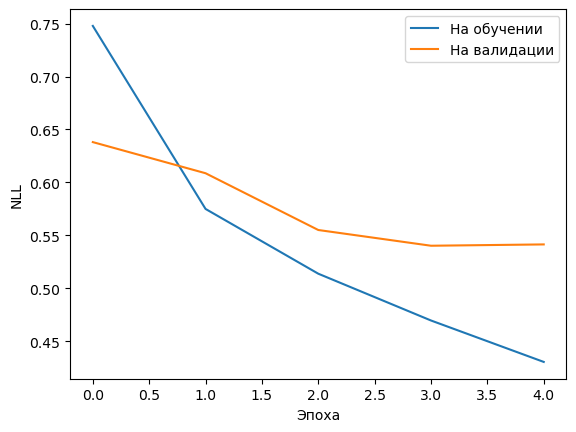

In [28]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.xlabel('Эпоха')
plt.ylabel('NLL')
plt.legend(['На обучении', 'На валидации']);

In [29]:
NUM_CLASSES=3

In [30]:
def calculate_metrics(target_test, predictions, probabilities):
    acc = accuracy_score(target_test, predictions)
    cmatrix = confusion_matrix(target_test, predictions)

    ap, roc_auc, fpr, tpr, precision, recall, thresholds, f_scores, best_f, best_thresh = ([0 for i in range(NUM_CLASSES)] for j in range(10))

    target_vector = label_binarize(target_test, classes=range(NUM_CLASSES))
    for i in range(NUM_CLASSES):
        ap[i] = average_precision_score(target_vector[:, i], probabilities[:, i])
        fpr[i], tpr[i], _ = roc_curve(target_vector[:, i], probabilities[:, i])
        try:
            roc_auc[i] = roc_auc_score(target_vector[:, i], probabilities[:, i])
        except:
            roc_auc[i] = 0

        precision[i], recall[i], thresholds[i] = precision_recall_curve(target_vector[:, i], probabilities[:, i])
        # You may adjust the beta here:
        beta = 1
        f_scores[i] = (1 + beta ** 2) * recall[i] * precision[i] / (recall[i] + beta ** 2 * precision[i])
        best_thresh[i] = thresholds[i][np.argmax(f_scores[i])]
        best_f[i] = np.max(f_scores[i])

    return best_f, roc_auc, acc, ap, best_thresh, beta, fpr, tpr, recall, precision, cmatrix

In [31]:
def visualize(target_test, probabilities):
    predictions = probabilities.argmax(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(13,5))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    best_f, roc_auc, acc, ap, best_thresh, beta, fpr, tpr, recall, precision, cmatrix = calculate_metrics(target_test, predictions, probabilities)
    for i in range(NUM_CLASSES):
        axes[0].plot (fpr[i], tpr[i]);
        axes[1].plot (recall[i], precision[i], label=f'{i} - ROC_AUC: {roc_auc[i]:.2f}, AP: {ap[i]:.2f}, лучшая {r"$F_{"+str(beta)+r"}$"}: {best_f[i]:.2f} с порогом {best_thresh[i]:.2f}');
   
    axes[1].legend(loc='best')
    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC-кривые', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR-кривые', xlim=(0,1), ylim=(0,1))
    
    plt.show()
    fig, axes = plt.subplots(1, 1, figsize=(7,5))
    sns.heatmap(cmatrix, annot=True, cmap='Blues', fmt='d').set(title='Матрица ошибок', xlabel='Предсказание', ylabel='Реальность')

    unpacked_thresholds = [best_thresh[i] for i in range(NUM_CLASSES)]

    return unpacked_thresholds

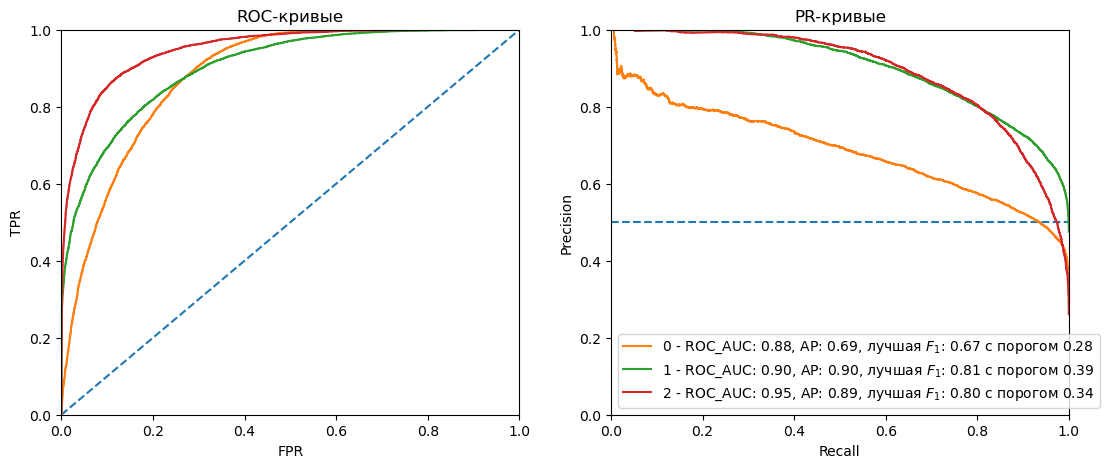

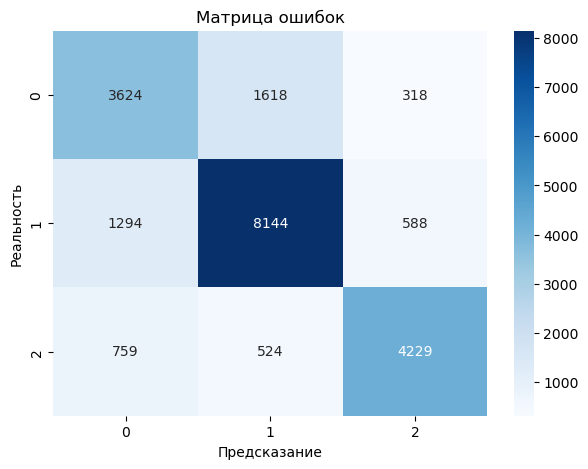

In [32]:
predictions = []
labels = []
with torch.no_grad():
    for x, y in test_dl:
        predictions.extend(torch.softmax(model(x), dim=1))
        labels.extend(y)
predictions = torch.vstack(predictions).cpu().numpy()
labels = torch.vstack(labels).cpu().numpy()
visualize(labels, predictions);

## Huggingface: токенизаторы

In [33]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [35]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

In [36]:
def tokenize(batch, column='clean_text'):
    return tokenizer(batch[column], padding='max_length', truncation=True, max_length=256)

In [37]:
train_set = train_set.map(tokenize, batched=True, batch_size=64)
test_set = test_set.map(tokenize, batched=True, batch_size=64)

Map:   0%|          | 0/189891 [00:00<?, ? examples/s]

Map:   0%|          | 0/21098 [00:00<?, ? examples/s]

In [38]:
[tokenizer.decode(id) for id in train_set[9]['input_ids']][:20]

['[CLS]',
 'второй',
 'раз',
 'останавлива',
 '##юсь',
 'в',
 'этом',
 'отеле',
 'с',
 'первых',
 'минут',
 'все',
 'тебя',
 'начинают',
 'радовать',
 'особенно',
 'при',
 'сравнении',
 'с',
 'звезд']

In [39]:
train_ds = DictDataset(train_set)
test_ds = DictDataset(test_set)

In [40]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=12)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=batch_size, num_workers=12)

In [41]:
model = WordLM(vocab_size=tokenizer.vocab_size, padding_idx=tokenizer.vocab['[PAD]'])
optim = Adam(model.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()

In [42]:
model, optim, train_dl, test_dl = accelerator.prepare(model, optim, train_dl, test_dl)

In [43]:
train_loss, test_loss = train(model, optim, loss)

  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 0: accuracy на валидации: 70.90%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 1: accuracy на валидации: 73.52%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 2: accuracy на валидации: 75.03%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 3: accuracy на валидации: 75.21%


  0%|          | 0/742 [00:00<?, ?it/s]

Эпоха 4: accuracy на валидации: 74.54%


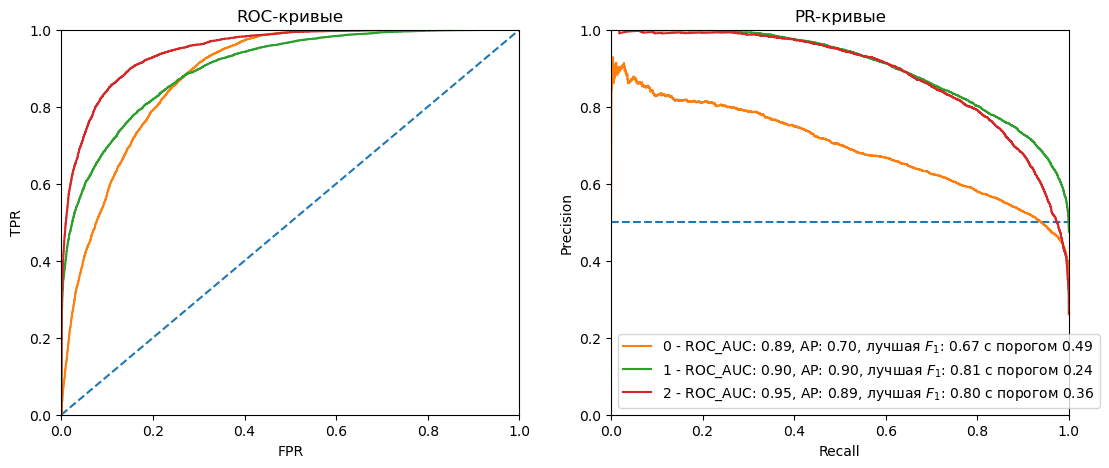

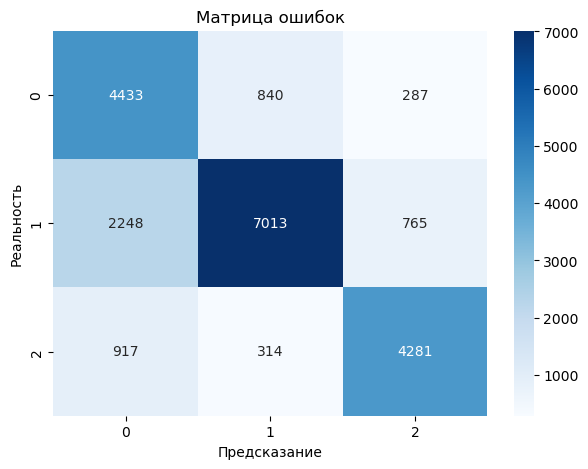

In [44]:
predictions = []
labels = []
with torch.no_grad():
    for x, y in test_dl:
        predictions.extend(torch.softmax(model(x), dim=1))
        labels.extend(y)
predictions = torch.vstack(predictions).cpu().numpy()
labels = torch.vstack(labels).cpu().numpy()
visualize(labels, predictions);

## Huggingface: модели и высокоуровневые утилиты обучения

In [58]:
rubert = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=3)

In [46]:
torchinfo.summary(rubert, input_size=(16, 256), dtypes=[torch.long])

Layer (type:depth-idx)                                  Output Shape              Param #
BertForSequenceClassification                           [16, 3]                   --
├─BertModel: 1-1                                        [16, 312]                 --
│    └─BertEmbeddings: 2-1                              [16, 256, 312]            --
│    │    └─Embedding: 3-1                              [16, 256, 312]            26,154,336
│    │    └─Embedding: 3-2                              [16, 256, 312]            624
│    │    └─Embedding: 3-3                              [1, 256, 312]             638,976
│    │    └─LayerNorm: 3-4                              [16, 256, 312]            624
│    │    └─Dropout: 3-5                                [16, 256, 312]            --
│    └─BertEncoder: 2-2                                 [16, 256, 312]            --
│    │    └─ModuleList: 3-6                             --                        2,301,552
│    └─BertPooler: 2-3                

In [48]:
clean_train = train_set.select_columns(['input_ids', 'token_type_ids', 'attention_mask', 'sentiment']).rename_column("sentiment", "labels")
clean_test = test_set.select_columns(['input_ids', 'token_type_ids', 'attention_mask', 'sentiment']).rename_column("sentiment", "labels")

In [59]:
rubert = accelerator.prepare(rubert)

In [60]:
training_args = TrainingArguments(
                                    output_dir='rubert',
                                    num_train_epochs=5,
                                    learning_rate=5e-5,
                                    per_device_train_batch_size=64,
                                    per_device_eval_batch_size=64,
                                    optim="adamw_torch",
                                    weight_decay=5e-7,
                                    #lr_scheduler_type='cosine',
                                    evaluation_strategy="epoch",
                                    save_strategy="epoch",
                                    disable_tqdm=False,
                                    logging_steps=len(train_set) // batch_size,
                                    push_to_hub=False,
                                    report_to='none',
                                    log_level="error",
                                    seed=177013,
                                    load_best_model_at_end=True,
                                    #metric_for_best_model='f1',
                                  )

In [61]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [62]:
trainer = Trainer(
                    model=rubert,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=clean_train,
                    eval_dataset=clean_test,
                    tokenizer=tokenizer
                 )

In [63]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.480000,0.477382,0.781448,0.781448
2,0.405300,0.445081,0.798891,0.798891
3,0.348500,0.467691,0.798559,0.798559
4,0.301700,0.493482,0.796426,0.796426
5,0.262800,0.523869,0.793725,0.793725


In [64]:
predictions = trainer.predict(clean_test).predictions
labels = clean_test['labels']

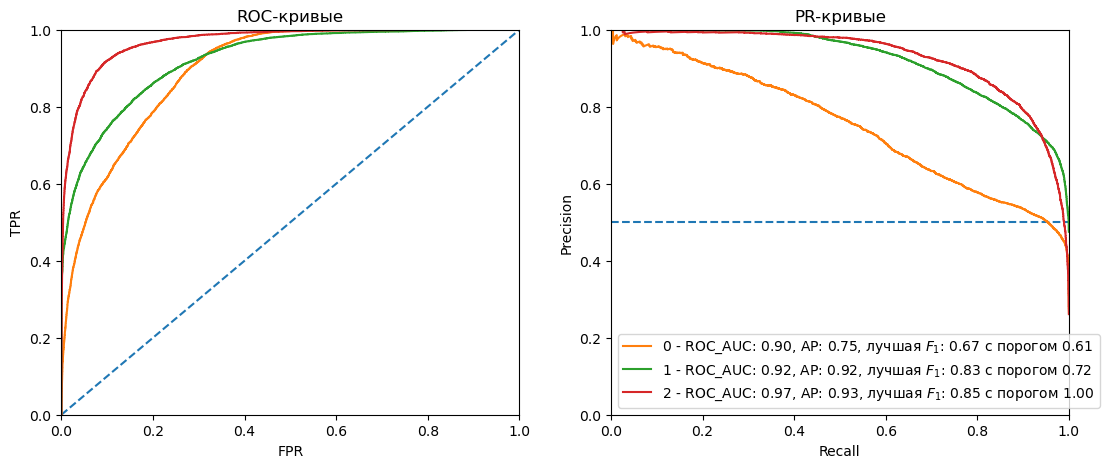

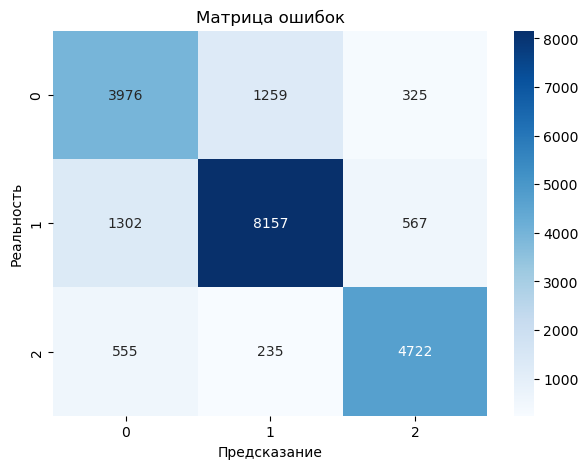

In [65]:
visualize(labels, predictions);

## Языковое моделирование с помощью рекуррентной сети

In [66]:
class SeqDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.as_tensor(self.data[idx]['input_ids'][:-1]).long(), torch.as_tensor(self.data[idx]['input_ids'][1:]).long()

In [67]:
batch_size=64

In [71]:
def tokenize(df, max_len=32, column='clean_text'):
    word_list = df[column].split()[:max_len-2]
    token_list = [word2ind['[CLS]']]
    token_list.extend(word2ind.get(word, word2ind['[UNK]']) for word in word_list)
    token_list.append(word2ind['[SEP]'])
    token_list.extend(word2ind['[PAD]'] for i in range(max_len - len(word_list) - 2))
    return {'input_ids': token_list}

In [72]:
train_set = train_set.map(tokenize)
test_set = test_set.map(tokenize)

Map:   0%|          | 0/189891 [00:00<?, ? examples/s]

Map:   0%|          | 0/21098 [00:00<?, ? examples/s]

In [73]:
train_ds = SeqDataset(train_set)
test_ds = SeqDataset(test_set)

In [74]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=12)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=batch_size, num_workers=12)

In [75]:
len(vocab)

47380

In [76]:
class WordLM(nn.Module):
    def __init__(self, hidden_dim=256, vocab_size=len(vocab), 
        num_layers = 1,
        dropout = 0.5, padding_idx=word2ind['[PAD]']
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=padding_idx)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)
        output, hidden = self.rnn(embeddings)
        drop = self.dropout(output)
        prediction = self.projection(drop)
        return prediction

In [77]:
model = WordLM()
optim = Adam(model.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss(ignore_index=word2ind['[PAD]'])

In [78]:
model, optim, train_dl, test_dl = accelerator.prepare(model, optim, train_dl, test_dl)

In [81]:
def train(model, optimizer, loss_func, num_epochs=10):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        for xb, yb in tqdm(train_dl):
            pred = model(xb)
            loss = loss_func(pred.flatten(start_dim=0, end_dim=1), yb.flatten())
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.cpu().detach().numpy()
        train_loss.append(total_loss/len(train_dl))
    
        total_loss = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in test_dl:
                pred = model(xb).flatten(start_dim=0, end_dim=1)
                loss = loss_func(pred, yb.flatten())
                total_loss += loss.cpu().numpy()
            test_loss.append(total_loss/len(test_dl))
        print(f'Эпоха {epoch}: perplexity на валидации: {np.exp(test_loss[-1]):.2f}')
    return train_loss, test_loss

In [82]:
train_loss, test_loss = train(model, optim, loss)

  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 0: perplexity на валидации: 465.60


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 1: perplexity на валидации: 390.66


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 2: perplexity на валидации: 349.34


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 3: perplexity на валидации: 326.21


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 4: perplexity на валидации: 305.34


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 5: perplexity на валидации: 294.36


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 6: perplexity на валидации: 287.27


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 7: perplexity на валидации: 302.98


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 8: perplexity на валидации: 267.77


  0%|          | 0/2968 [00:00<?, ?it/s]

Эпоха 9: perplexity на валидации: 261.17


In [83]:
torch.cuda.empty_cache()

In [84]:
def generate_sequence(model, starting_seq, max_len = 1024):
    input_ids = [word2ind['[CLS]']] + [word2ind.get(word, word2ind['[UNK]']) for word in starting_seq.lower().split()]
    input_ids = torch.LongTensor(input_ids).to(accelerator.device)

    model.eval()
    with torch.no_grad():
        for i in range(max_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['[SEP]']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [108]:
generate_sequence(model, 'Второй раз останавливаюсь')

'[CLS] второй раз останавливаюсь в этом отеле в этом отеле очень понравилось расположение отеля в центре города рядом с отелем есть супермаркет и [UNK] и [UNK] и [UNK] и [UNK] и [SEP]'

In [111]:
generate_sequence(model, 'Нормальный ресторан')

'[CLS] нормальный ресторан в центре москвы в центре города в центре города в шаговой доступности от метро и [UNK] и [UNK] [UNK] и [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [SEP]'

In [98]:
generate_sequence(model, 'Ужасное')

'[CLS] ужасное отношение к пациентам в регистратуре работают в регистратуре в регистратуре не берут трубку не берут трубку не берут трубку не берут трубку не берут трубку не берут трубку [SEP]'

## Huggingface: LM на предобученных моделях

In [237]:
from transformers import pipeline

generator = pipeline("text2text-generation", model="IlyaGusev/fred_t5_ru_turbo_alpaca", tokenizer="IlyaGusev/fred_t5_ru_turbo_alpaca", device_map='auto', torch_dtype='auto', )

In [323]:
input_text = "Нормальный ресторан"
output = generator(input_text, max_length=50, temperature=0.9)
print(output[0]['generated_text'])

К сожалению, я не могу описать свой любимый ресторан, так как я являюсь искусственным интеллектом и не обладаю вкусовыми предпочтениями.


In [324]:
input_text = "У меня было 5 бананов. Я купил еще 3 яблока. Сколько у меня теперь бананов? Ответ:"
output = generator(input_text, max_length=50, do_sample=True, temperature=0.8)
print(output[0]['generated_text'])

Ответ: 11.


In [326]:
input_text = "Как приготовить лазанью?"
output = generator(input_text, max_length=220)
print(output[0]['generated_text'])

Лазанья - это традиционное итальянское блюдо, состоящее из листов лазаньи, мясного соуса болоньезе, сыра моцарелла и томатного соуса.

Ингредиенты:
- листы лазаньи
- мясной соус болоньезе
- томатный соус
- моцарелла
- пармезан
- соль
- перец
- оливковое масло

Инструкции:

1. Разогрейте духовку до 180 градусов.

2. Разложите листы лазаньи на противне.

3. Добавьте мясной соус болоньезе и томатный соус.

4. Посыпьте пармезаном.

5. Поставьте в духовку на 10-15 минут.

6. Выньте листы лазаньи из духовки.

7. Переложите листы лазаньи на тарелку.

8. Посолите и поперчите по вкусу.

9. Подавайте горячей


## Few-shot learning с T5

In [110]:
from transformers import T5ForConditionalGeneration

In [111]:
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')

In [113]:
optimizer = AdamW(t5_model.parameters() , lr=3e-4)

In [114]:
true_false_adjective_tuples = [
                               ("The cat is alive","The cat is dead"),
                               ("The old woman is beautiful","The old woman is ugly"),
                               ("The purse is cheap","The purse is expensive"),
                               ("Her hair is curly","Her hair is straight"),
                               ("The bathroom is clean","The bathroom is dirty"),
                               ("The exam was easy","The exam was difficult"),
                               ("The house is big","The house is small"),
                               ("The house owner is good","The house owner is bad"),
                               ("The little kid is fat","The little kid is thin"),
                               ("She arrived early","She arrived late."),
                               ("John is very hardworking","John is very lazy"),
                               ("The fridge is empty","The fridge is full")

]

In [115]:
t5_model.train()

epochs = 50

for epoch in tqdm(range(epochs)):
  for input,output in true_false_adjective_tuples:
    input_sent = "falsify: " + input
    ouput_sent = output

    tokenized_inp = tokenizer(input_sent, padding='max_length', truncation=True, max_length=96, return_tensors="pt")
    tokenized_output = tokenizer(ouput_sent, padding='max_length', truncation=True, max_length=96, return_tensors="pt")

    input_ids  = tokenized_inp["input_ids"]
    attention_mask = tokenized_inp["attention_mask"]

    lm_labels = tokenized_output["input_ids"]
    decoder_attention_mask =  tokenized_output["attention_mask"]

    output = t5_model(input_ids=input_ids, labels=lm_labels, decoder_attention_mask=decoder_attention_mask, attention_mask=attention_mask)
    loss = output[0]

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

In [116]:
def t5_inference(prompt, model, tokenizer):
    test_tokenized = tokenizer(prompt, padding='max_length', truncation=True, max_length=96, return_tensors="pt")
    test_input_ids  = test_tokenized["input_ids"]
    test_attention_mask = test_tokenized["attention_mask"]

    t5_model.eval()
    beam_outputs = t5_model.generate(
            input_ids=test_input_ids,
            attention_mask=test_attention_mask,
            max_length=64,
            early_stopping=True,
            num_beams=10,
            num_return_sequences=3,
            no_repeat_ngram_size=2
    )

    for beam_output in beam_outputs:
        print(tokenizer.decode(beam_output, skip_special_tokens=True, clean_up_tokenization_spaces=True))

In [117]:
t5_inference('falsify: The sailor was happy and joyful.', t5_model, tokenizer)

The sail was unhappy.
The sail was unhappy
The sail was sad.


In [118]:
t5_inference("'falsify: The cat is fat.", t5_model, tokenizer)

The cat is thin
The cat is thin.
the cat is thin
